In [1]:
CORE_COUNT = 16

import os

# Limit all relevant threading environments to 1 core
os.environ["OMP_NUM_THREADS"] = str(CORE_COUNT)
os.environ["OPENBLAS_NUM_THREADS"] = str(CORE_COUNT)
os.environ["MKL_NUM_THREADS"] = str(CORE_COUNT)
os.environ["VECLIB_MAXIMUM_THREADS"] = str(CORE_COUNT)
os.environ["NUMEXPR_NUM_THREADS"] = str(CORE_COUNT)
os.environ["STIM_NUM_THREADS"] = str(CORE_COUNT)  # for Stim if it respects this


In [ ]:
import sys
sys.path.append("../")
from clapton.clapton import claptonize, claptonize_opt, claptonize_opt_scipy, claptonize_opt_ng
from clapton.ansatzes import circular_ansatz
from clapton.utils import Results
import numpy as np
import pickle
import time
import copy


from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import JordanWignerMapper, ParityMapper
from qiskit_nature.second_q.transformers import ActiveSpaceTransformer
from qiskit_nature.second_q.algorithms import GroundStateEigensolver
from qiskit_algorithms import NumPyMinimumEigensolver
from qiskit_nature.second_q.problems import ElectronicStructureProblem

from optuna.samplers import TPESampler, RandomSampler, GridSampler, CmaEsSampler, QMCSampler, GPSampler, NSGAIIISampler, NSGAIISampler


import nevergrad as ng
# from nevergrad.families import NonObjectOptimizer
# from nevergrad.optimizers import NGOpt
from nevergrad.optimization.optimizerlib import EDA, ConfPSO, ParametrizedOnePlusOne, cGA, NoisySplit, MultiDiscrete, AXP, BFGSCMAPlus, CMA, CSEC11, Carola3, ChoiceBase, ForceMultiCobyla, \
    LogMultiBFGSPlus, MEDA, MetaCMA, MultiBFGSPlus, MultiCobylaPlus, MultiSQPPlus, NGO, PCEDA, SPSA, SQPCMAPlus, Shiwa, SplitOptimizer, Wiz


ModuleNotFoundError: No module named 'nevergrad.optimizers'

In [3]:

def generate_h2o_geometry(bond_length: float) -> str:
    """
    Generate H2O geometry with both O–H bonds of equal length,
    forming an angle of ~104.5 degrees.
    """
    angle_deg = 104.5
    angle_rad = np.deg2rad(angle_deg / 2)

    x = bond_length * np.sin(angle_rad)
    z = bond_length * np.cos(angle_rad)

    geometry_str = (
        f"O 0.0 0.0 0.0; "
        f"H {x:.6f} 0.0 {z:.6f}; "
        f"H {-x:.6f} 0.0 {z:.6f}"
    )
    return geometry_str

def generate_linear_h6_geometry(bond_length: float) -> str:
    coords = []
    for i in range(6):
        z = i * bond_length
        coords.append(f"H 0.0 0.0 {z:.6f}")
    return "; ".join(coords)


def generate_ring_h6_geometry(bond_length: float) -> str:
    # Radius r from bond length of regular hexagon
    r = bond_length / (2 * np.sin(np.pi / 6))
    coords = []
    for i in range(6):
        angle = i * np.pi / 3  # 60° steps
        x = r * np.cos(angle)
        y = r * np.sin(angle)
        coords.append(f"H {x:.6f} {y:.6f} 0.0")
    return "; ".join(coords)


In [4]:
hamiltonian_strings = []
hamiltonian_strings += [f"H 0 0 0; H 0 0 {bond_length :.3f}" for bond_length in np.arange(0.37, 3.0, 0.1)]
# hamiltonian_strings += [f"Li 0 0 0; H 0 0 {bond_length :.3f}" for bond_length in np.arange(0.8, 4.8, 0.1)]
# hamiltonian_strings += [generate_h2o_geometry(bond_length) for bond_length in np.arange(0.5, 4.0, 0.1)]
# hamiltonian_strings += [generate_ring_h6_geometry(bond_length) for bond_length in np.arange(0.45, 3.6, 0.1)]
print(hamiltonian_strings)


# exact_results = Results("exact")
# GA_results = Results("GA")

# "Nelder-Mead", "L-BFGS-B", "COBYLA", "trust-constr"
# for sampler_ in [AXP, BFGSCMAPlus, CMA, CSEC11, Carola3, ChoiceBase, ForceMultiCobyla]:
for sampler_ in [LogMultiBFGSPlus, MEDA, MetaCMA, MultiBFGSPlus, MultiCobylaPlus, MultiSQPPlus, NGO, PCEDA, SPSA, SQPCMAPlus, Shiwa, SplitOptimizer, Wiz]:
# for sampler_ in [MultiDiscrete, AXP, BFGSCMAPlus, CMA, CSEC11, Carola3, ChoiceBase, ForceMultiCobyla]:
# for sampler_ in [QMCSampler, NSGAIIISampler, NSGAIISampler]:
    optimizer_name = sampler_.__name__
    print(f"Using sampler: {optimizer_name}")
    # if optimizer_name == "QMCSampler":
    #     continue  # Skip QMC for now
    
    # GA_results = Results(f"GA-{optimizer_name}")
    # exact_results = Results(f"exact-{optimizer_name}")
    optuna_results = Results(f"ng-{optimizer_name}")

    for i, hamiltonian_string in enumerate(hamiltonian_strings):
        print(f"=================================")
        print(f"Starting {i+1}/{len(hamiltonian_strings)}: {hamiltonian_string}")
        print(f"=================================")
        driver = PySCFDriver(atom=hamiltonian_string, basis="sto-3g")
        problem = driver.run()
        second_q_op = problem.hamiltonian.second_q_op()

        mapper = ParityMapper()
        qubit_op = mapper.map(second_q_op)

        paulis_ = qubit_op.paulis.to_labels()
        coeffs_ = qubit_op.coeffs
        
        if np.all(np.abs(coeffs_.imag) < 1e-10) is False:
            print(f"Skipping {hamiltonian_string} due to complex coefficients.")
            continue

        # numpy_solver = NumPyMinimumEigensolver()
        # calc = GroundStateEigensolver(mapper, numpy_solver)

        # exact_time = time.time()
        # res = calc.solve(problem)
        # exact_time = time.time() - exact_time
        # exact_results.add_result(hamiltonian_string, paulis_, coeffs_.real.astype(float).tolist(), exact_time, 0, float(res.groundenergy))
        
        
        #############################
        
        coeffs_ = coeffs_.real.astype(float)

        vqe_pcirc_ = circular_ansatz(N=len(paulis_[0]), reps=1, fix_2q=True)


        # vqe_pcirc = copy.deepcopy(vqe_pcirc_)
        # paulis = copy.deepcopy(paulis_)
        # coeffs = copy.deepcopy(coeffs_)

        # GA_time = time.time()
        # ks_best, _, energy_best = claptonize(
        #     paulis,
        #     coeffs,
        #     vqe_pcirc,
        #     n_proc=CORE_COUNT,           # total number of processes in parallel
        #     n_starts=4,         # number of random genetic algorithm starts in parallel
        #     n_rounds=1,         # number of budget rounds, if None it will terminate itself
        #     # callback=print,     # callback for internal parameter (#iteration, energies, ks) processing
        #     budget=20           # budget per genetic algorithm instance
        # )
        # GA_time = time.time() - GA_time

        # GA_results.add_result(hamiltonian_string, paulis, coeffs.tolist(), GA_time, ks_best, float(energy_best))

        vqe_pcirc = copy.deepcopy(vqe_pcirc_)
        paulis = copy.deepcopy(paulis_)
        coeffs = copy.deepcopy(coeffs_)

        optuna_time = time.time()
        ks_best, _, energy_best = claptonize_opt_ng(
            paulis,
            coeffs,
            vqe_pcirc,
            ng_optimizer=sampler_   ,  # "Nelder-Mead", "L-BFGS-B", "COBYLA", "trust-constr"
        )
        optuna_time = time.time() - optuna_time
        optuna_results.add_result(hamiltonian_string, paulis, coeffs.tolist(), optuna_time, ks_best, float(energy_best))
        
        
        

        # with open("results/exact", "wb") as file:
        #     pickle.dump(exact_results, file)
        # with open(f"results/GA-{CORE_COUNT}-core", "wb") as file:
        #     pickle.dump(GA_results, file)
        with open(f"results/ng-{optimizer_name}-{CORE_COUNT}-core", "wb") as file:
            pickle.dump(optuna_results, file)
            

['H 0 0 0; H 0 0 0.370', 'H 0 0 0; H 0 0 0.470', 'H 0 0 0; H 0 0 0.570', 'H 0 0 0; H 0 0 0.670', 'H 0 0 0; H 0 0 0.770', 'H 0 0 0; H 0 0 0.870', 'H 0 0 0; H 0 0 0.970', 'H 0 0 0; H 0 0 1.070', 'H 0 0 0; H 0 0 1.170', 'H 0 0 0; H 0 0 1.270', 'H 0 0 0; H 0 0 1.370', 'H 0 0 0; H 0 0 1.470', 'H 0 0 0; H 0 0 1.570', 'H 0 0 0; H 0 0 1.670', 'H 0 0 0; H 0 0 1.770', 'H 0 0 0; H 0 0 1.870', 'H 0 0 0; H 0 0 1.970', 'H 0 0 0; H 0 0 2.070', 'H 0 0 0; H 0 0 2.170', 'H 0 0 0; H 0 0 2.270', 'H 0 0 0; H 0 0 2.370', 'H 0 0 0; H 0 0 2.470', 'H 0 0 0; H 0 0 2.570', 'H 0 0 0; H 0 0 2.670', 'H 0 0 0; H 0 0 2.770', 'H 0 0 0; H 0 0 2.870', 'H 0 0 0; H 0 0 2.970']
Using sampler: LogMultiBFGSPlus
Starting 1/27: H 0 0 0; H 0 0 0.370
Instrumentation(Tuple(Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),Softmax

/clusterfs/students/santana/clapton/venv/lib/python3.11/site-packages/nevergrad/optimization/base.py:149: InefficientSettingsWarning: num_workers = 6 > 1 is suboptimal when run sequentially
  warnings.warn(msg, e)


(2, 2, 2, 0, 2, 2, 1, 1, 3, 3, 0, 0, 3, 0, 3, 1)
Starting 2/27: H 0 0 0; H 0 0 0.470
Instrumentation(Tuple(Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(ch

/clusterfs/students/santana/clapton/venv/lib/python3.11/site-packages/nevergrad/optimization/base.py:149: InefficientSettingsWarning: num_workers = 6 > 1 is suboptimal when run sequentially
  warnings.warn(msg, e)


(3, 1, 0, 2, 3, 3, 3, 0, 1, 0, 2, 0, 3, 0, 0, 0)
Starting 3/27: H 0 0 0; H 0 0 0.570
Instrumentation(Tuple(Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(ch

/clusterfs/students/santana/clapton/venv/lib/python3.11/site-packages/nevergrad/optimization/base.py:149: InefficientSettingsWarning: num_workers = 6 > 1 is suboptimal when run sequentially
  warnings.warn(msg, e)


(1, 0, 3, 3, 2, 1, 2, 0, 0, 0, 1, 1, 1, 2, 3, 1)
Starting 4/27: H 0 0 0; H 0 0 0.670
Instrumentation(Tuple(Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(ch

/clusterfs/students/santana/clapton/venv/lib/python3.11/site-packages/nevergrad/optimization/base.py:149: InefficientSettingsWarning: num_workers = 6 > 1 is suboptimal when run sequentially
  warnings.warn(msg, e)


(1, 2, 0, 1, 2, 3, 3, 2, 0, 2, 1, 1, 1, 3, 0, 3)
Starting 5/27: H 0 0 0; H 0 0 0.770
Instrumentation(Tuple(Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(ch

/clusterfs/students/santana/clapton/venv/lib/python3.11/site-packages/nevergrad/optimization/base.py:149: InefficientSettingsWarning: num_workers = 6 > 1 is suboptimal when run sequentially
  warnings.warn(msg, e)


(1, 0, 2, 2, 0, 2, 2, 0, 0, 0, 0, 2, 2, 1, 3, 2)
Starting 6/27: H 0 0 0; H 0 0 0.870
Instrumentation(Tuple(Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(ch

/clusterfs/students/santana/clapton/venv/lib/python3.11/site-packages/nevergrad/optimization/base.py:149: InefficientSettingsWarning: num_workers = 6 > 1 is suboptimal when run sequentially
  warnings.warn(msg, e)


(1, 2, 2, 2, 3, 1, 3, 2, 3, 2, 2, 0, 0, 2, 1, 1)
Starting 7/27: H 0 0 0; H 0 0 0.970
Instrumentation(Tuple(Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(ch

/clusterfs/students/santana/clapton/venv/lib/python3.11/site-packages/nevergrad/optimization/base.py:149: InefficientSettingsWarning: num_workers = 6 > 1 is suboptimal when run sequentially
  warnings.warn(msg, e)


(3, 0, 0, 0, 0, 1, 1, 3, 1, 2, 0, 0, 2, 3, 1, 1)
Starting 8/27: H 0 0 0; H 0 0 1.070
Instrumentation(Tuple(Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(ch

/clusterfs/students/santana/clapton/venv/lib/python3.11/site-packages/nevergrad/optimization/base.py:149: InefficientSettingsWarning: num_workers = 6 > 1 is suboptimal when run sequentially
  warnings.warn(msg, e)


(0, 0, 0, 2, 3, 3, 0, 2, 2, 3, 0, 2, 1, 3, 3, 0)
Starting 9/27: H 0 0 0; H 0 0 1.170
Instrumentation(Tuple(Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(ch

/clusterfs/students/santana/clapton/venv/lib/python3.11/site-packages/nevergrad/optimization/base.py:149: InefficientSettingsWarning: num_workers = 6 > 1 is suboptimal when run sequentially
  warnings.warn(msg, e)


(2, 0, 2, 2, 0, 2, 1, 1, 1, 0, 0, 2, 2, 1, 3, 0)
Starting 10/27: H 0 0 0; H 0 0 1.270
Instrumentation(Tuple(Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(c

/clusterfs/students/santana/clapton/venv/lib/python3.11/site-packages/nevergrad/optimization/base.py:149: InefficientSettingsWarning: num_workers = 6 > 1 is suboptimal when run sequentially
  warnings.warn(msg, e)


(2, 2, 0, 0, 2, 3, 0, 3, 2, 2, 0, 0, 1, 2, 1, 1)
Starting 11/27: H 0 0 0; H 0 0 1.370
Instrumentation(Tuple(Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(c

/clusterfs/students/santana/clapton/venv/lib/python3.11/site-packages/nevergrad/optimization/base.py:149: InefficientSettingsWarning: num_workers = 6 > 1 is suboptimal when run sequentially
  warnings.warn(msg, e)


(2, 3, 0, 0, 3, 3, 1, 2, 2, 2, 0, 0, 2, 0, 1, 0)
Starting 12/27: H 0 0 0; H 0 0 1.470
Instrumentation(Tuple(Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(c

/clusterfs/students/santana/clapton/venv/lib/python3.11/site-packages/nevergrad/optimization/base.py:149: InefficientSettingsWarning: num_workers = 6 > 1 is suboptimal when run sequentially
  warnings.warn(msg, e)


(1, 1, 3, 1, 2, 2, 3, 2, 3, 1, 1, 3, 0, 2, 3, 3)
Starting 13/27: H 0 0 0; H 0 0 1.570
Instrumentation(Tuple(Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(c

/clusterfs/students/santana/clapton/venv/lib/python3.11/site-packages/nevergrad/optimization/base.py:149: InefficientSettingsWarning: num_workers = 6 > 1 is suboptimal when run sequentially
  warnings.warn(msg, e)


(3, 2, 2, 0, 3, 1, 1, 3, 3, 0, 0, 0, 1, 1, 2, 0)
Starting 14/27: H 0 0 0; H 0 0 1.670
Instrumentation(Tuple(Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(c

/clusterfs/students/santana/clapton/venv/lib/python3.11/site-packages/nevergrad/optimization/base.py:149: InefficientSettingsWarning: num_workers = 6 > 1 is suboptimal when run sequentially
  warnings.warn(msg, e)


(2, 3, 0, 0, 1, 2, 1, 0, 2, 2, 1, 0, 1, 1, 1, 1)
Starting 15/27: H 0 0 0; H 0 0 1.770
Instrumentation(Tuple(Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(c

/clusterfs/students/santana/clapton/venv/lib/python3.11/site-packages/nevergrad/optimization/base.py:149: InefficientSettingsWarning: num_workers = 6 > 1 is suboptimal when run sequentially
  warnings.warn(msg, e)


(1, 1, 3, 1, 0, 0, 0, 2, 3, 3, 3, 1, 3, 1, 3, 0)
Starting 16/27: H 0 0 0; H 0 0 1.870
Instrumentation(Tuple(Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(c

/clusterfs/students/santana/clapton/venv/lib/python3.11/site-packages/nevergrad/optimization/base.py:149: InefficientSettingsWarning: num_workers = 6 > 1 is suboptimal when run sequentially
  warnings.warn(msg, e)


(0, 3, 0, 2, 1, 1, 2, 3, 1, 2, 0, 2, 3, 3, 3, 3)
Starting 17/27: H 0 0 0; H 0 0 1.970
Instrumentation(Tuple(Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(c

/clusterfs/students/santana/clapton/venv/lib/python3.11/site-packages/nevergrad/optimization/base.py:149: InefficientSettingsWarning: num_workers = 6 > 1 is suboptimal when run sequentially
  warnings.warn(msg, e)


(2, 0, 3, 0, 0, 1, 2, 1, 2, 2, 0, 2, 0, 1, 2, 1)
Starting 18/27: H 0 0 0; H 0 0 2.070
Instrumentation(Tuple(Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(c

/clusterfs/students/santana/clapton/venv/lib/python3.11/site-packages/nevergrad/optimization/base.py:149: InefficientSettingsWarning: num_workers = 6 > 1 is suboptimal when run sequentially
  warnings.warn(msg, e)


(3, 2, 0, 0, 0, 1, 2, 3, 1, 2, 0, 0, 1, 0, 0, 0)
Starting 19/27: H 0 0 0; H 0 0 2.170
Instrumentation(Tuple(Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(c

/clusterfs/students/santana/clapton/venv/lib/python3.11/site-packages/nevergrad/optimization/base.py:149: InefficientSettingsWarning: num_workers = 6 > 1 is suboptimal when run sequentially
  warnings.warn(msg, e)


(0, 3, 1, 2, 2, 0, 1, 1, 2, 1, 1, 3, 2, 0, 1, 2)
Starting 20/27: H 0 0 0; H 0 0 2.270
Instrumentation(Tuple(Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(c

/clusterfs/students/santana/clapton/venv/lib/python3.11/site-packages/nevergrad/optimization/base.py:149: InefficientSettingsWarning: num_workers = 6 > 1 is suboptimal when run sequentially
  warnings.warn(msg, e)


(1, 2, 0, 2, 2, 3, 0, 3, 2, 2, 0, 2, 2, 0, 1, 1)
Starting 21/27: H 0 0 0; H 0 0 2.370
Instrumentation(Tuple(Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(c

/clusterfs/students/santana/clapton/venv/lib/python3.11/site-packages/nevergrad/optimization/base.py:149: InefficientSettingsWarning: num_workers = 6 > 1 is suboptimal when run sequentially
  warnings.warn(msg, e)


(3, 2, 2, 0, 3, 3, 1, 2, 0, 0, 0, 0, 3, 0, 0, 3)
Starting 22/27: H 0 0 0; H 0 0 2.470
Instrumentation(Tuple(Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(c

/clusterfs/students/santana/clapton/venv/lib/python3.11/site-packages/nevergrad/optimization/base.py:149: InefficientSettingsWarning: num_workers = 6 > 1 is suboptimal when run sequentially
  warnings.warn(msg, e)


(1, 0, 0, 2, 3, 1, 3, 1, 0, 2, 0, 2, 2, 3, 1, 1)
Starting 23/27: H 0 0 0; H 0 0 2.570
Instrumentation(Tuple(Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(c

/clusterfs/students/santana/clapton/venv/lib/python3.11/site-packages/nevergrad/optimization/base.py:149: InefficientSettingsWarning: num_workers = 6 > 1 is suboptimal when run sequentially
  warnings.warn(msg, e)


(1, 2, 0, 2, 2, 2, 2, 2, 2, 2, 0, 2, 3, 0, 0, 1)
Starting 24/27: H 0 0 0; H 0 0 2.670
Instrumentation(Tuple(Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(c

/clusterfs/students/santana/clapton/venv/lib/python3.11/site-packages/nevergrad/optimization/base.py:149: InefficientSettingsWarning: num_workers = 6 > 1 is suboptimal when run sequentially
  warnings.warn(msg, e)


(3, 3, 3, 1, 2, 2, 2, 0, 3, 3, 2, 1, 3, 3, 2, 1)
Starting 25/27: H 0 0 0; H 0 0 2.770
Instrumentation(Tuple(Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(c

/clusterfs/students/santana/clapton/venv/lib/python3.11/site-packages/nevergrad/optimization/base.py:149: InefficientSettingsWarning: num_workers = 6 > 1 is suboptimal when run sequentially
  warnings.warn(msg, e)


(2, 1, 2, 2, 0, 0, 0, 2, 0, 1, 3, 3, 1, 0, 3, 1)
Starting 26/27: H 0 0 0; H 0 0 2.870
Instrumentation(Tuple(Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(c

/clusterfs/students/santana/clapton/venv/lib/python3.11/site-packages/nevergrad/optimization/base.py:149: InefficientSettingsWarning: num_workers = 6 > 1 is suboptimal when run sequentially
  warnings.warn(msg, e)


(3, 2, 0, 0, 1, 2, 1, 2, 0, 0, 3, 2, 0, 1, 0, 1)
Starting 27/27: H 0 0 0; H 0 0 2.970
Instrumentation(Tuple(Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(c

/clusterfs/students/santana/clapton/venv/lib/python3.11/site-packages/nevergrad/optimization/base.py:149: InefficientSettingsWarning: num_workers = 6 > 1 is suboptimal when run sequentially
  warnings.warn(msg, e)


(1, 3, 2, 0, 0, 0, 3, 3, 1, 2, 2, 2, 2, 2, 2, 1)
Using sampler: MEDA
Starting 1/27: H 0 0 0; H 0 0 0.370
Instrumentation(Tuple(Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),SoftmaxSampling}),Choice(choices=Tuple(0,1,2,3),indices=Array{(1,4),Softmax

# Plotting

In [11]:
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(["science"])

In [12]:
def drop_laters(results: Results, count):
    """
    Drop later results in the list.
    """
    res = copy.deepcopy(results)
    res.bond_lengths = results.bond_lengths[:count]
    res.energy_bests = results.energy_bests[:count]
    res.times = results.times[:count]
    return res

In [24]:

results_list = []

with open("results/GA-16-core", "rb") as file:
    GA_results = pickle.load(file)
GA_results = drop_laters(GA_results, 27)
results_list += [GA_results]

with open("results/exact", "rb") as file:
    exact_results = pickle.load(file)
exact_results = drop_laters(exact_results, 27)
results_list += [exact_results]


# with open("results/optuna-QMC-16-core", "rb") as file:
#     optuna_results = pickle.load(file)
# optuna_results = drop_laters(optuna_results, 27)
# results_list += [optuna_results]

# with open("results/optuna-NSGAIII-16-core", "rb") as file:
#     optuna_results = pickle.load(file)
# optuna_results = drop_laters(optuna_results, 27)
# results_list += [optuna_results]

# with open("results/optuna-NSGAII-16-core", "rb") as file:
#     optuna_results = pickle.load(file)
# optuna_results = drop_laters(optuna_results, 27)
# results_list += [optuna_results]


# # with open("results/optuna-TPE-16-core", "rb") as file:
# #     optuna_results = pickle.load(file)
# # optuna_results = drop_laters(optuna_results, 27)
# # results_list += [optuna_results]


# with open("results/optuna-Random-16-core", "rb") as file:
#     optuna_results = pickle.load(file)
# optuna_results = drop_laters(optuna_results, 27)
# results_list += [optuna_results]


# with open("results/scipy-L-BFGS-B-16-core", "rb") as file:
#     optuna_results = pickle.load(file)
# optuna_results = drop_laters(optuna_results, 27)
# results_list += [optuna_results]

# with open("results/scipy-Nelder-Mead-16-core", "rb") as file:
#     optuna_results = pickle.load(file)
# optuna_results = drop_laters(optuna_results, 27)
# results_list += [optuna_results]


# with open("results/scipy-COBYLA-16-core", "rb") as file:
#     optuna_results = pickle.load(file)
# optuna_results = drop_laters(optuna_results, 27)
# results_list += [optuna_results]

# for temp_ in ["BFGSCMAPlus", "CMA", "CSEC11", "Carola3", "ChoiceBase", "ForceMultiCobyla"]:
for temp_ in ["cGA", "LogMultiBFGSPlus", "MEDA", "MetaCMA", "MultiBFGSPlus", "MultiCobylaPlus", "MultiSQPPlus", "NGO", "PCEDA", "SPSA", "SQPCMAPlus", "Shiwa", "SplitOptimizer", "Wiz"]:
# for temp_ in ["LogMultiBFGSPlus", "MEDA", "MetaCMA", "MultiBFGSPlus", "MultiCobylaPlus"]:

    with open(f"results/ng-{temp_}-16-core", "rb") as file:
        optuna_results = pickle.load(file)
    optuna_results = drop_laters(optuna_results, 27)
    results_list += [optuna_results]


In [25]:
print(optuna_results.ks_bests)

[(1, 0, 0, 0, 1, 1, 0, 0, 2, 2, 0, 0, 2, 3, 2, 0), (1, 0, 0, 0, 1, 0, 1, 2, 2, 2, 0, 0, 0, 2, 1, 0), (2, 1, 0, 2, 0, 2, 2, 3, 0, 0, 2, 0, 3, 1, 0, 1), (2, 1, 2, 0, 2, 0, 2, 2, 2, 2, 2, 2, 1, 2, 0, 1), (3, 0, 0, 2, 2, 2, 2, 2, 2, 2, 0, 3, 0, 0, 1, 2), (3, 2, 2, 2, 0, 2, 1, 2, 2, 0, 0, 2, 3, 1, 0, 2), (0, 2, 0, 0, 0, 2, 3, 2, 0, 0, 2, 2, 3, 2, 3, 0), (1, 3, 0, 0, 0, 2, 0, 3, 3, 2, 0, 0, 3, 1, 3, 3), (2, 1, 0, 2, 1, 3, 1, 3, 3, 2, 0, 2, 2, 2, 0, 0), (2, 2, 2, 2, 1, 1, 0, 2, 0, 2, 2, 3, 2, 1, 3, 1), (1, 1, 0, 2, 3, 0, 2, 1, 0, 2, 0, 2, 3, 3, 2, 0), (0, 1, 0, 1, 1, 1, 0, 1, 0, 2, 0, 0, 2, 1, 3, 3), (2, 0, 2, 2, 3, 0, 3, 1, 0, 0, 2, 2, 0, 3, 2, 3), (2, 3, 2, 2, 2, 2, 0, 0, 0, 0, 3, 2, 3, 0, 1, 1), (3, 0, 2, 3, 3, 3, 1, 1, 0, 2, 2, 3, 0, 2, 1, 0), (2, 3, 3, 2, 1, 1, 1, 3, 0, 3, 0, 2, 2, 1, 1, 2), (2, 0, 2, 2, 2, 1, 3, 2, 0, 0, 2, 2, 2, 1, 2, 1), (2, 0, 2, 0, 2, 3, 0, 0, 2, 2, 3, 2, 3, 3, 1, 0), (3, 3, 2, 1, 0, 1, 0, 2, 1, 1, 1, 1, 1, 3, 0, 0), (0, 2, 2, 0, 1, 1, 2, 3, 0, 2, 0, 2, 3, 0, 3, 3),

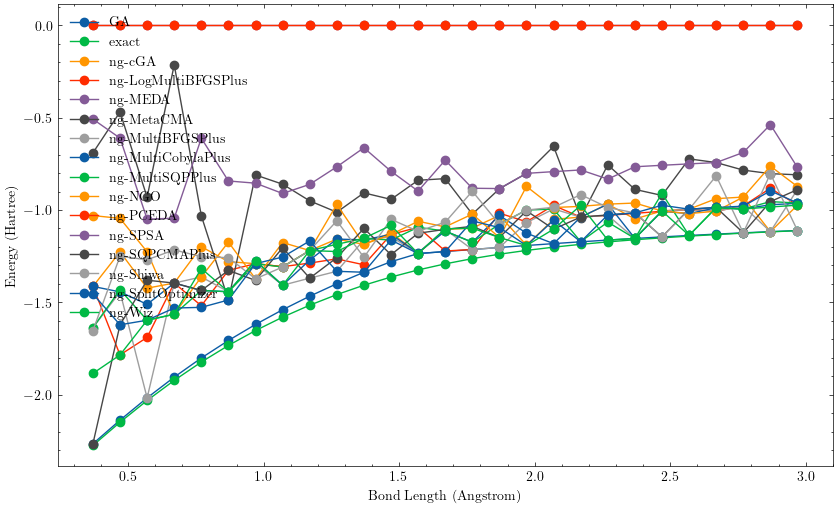

<Figure size 350x262.5 with 0 Axes>

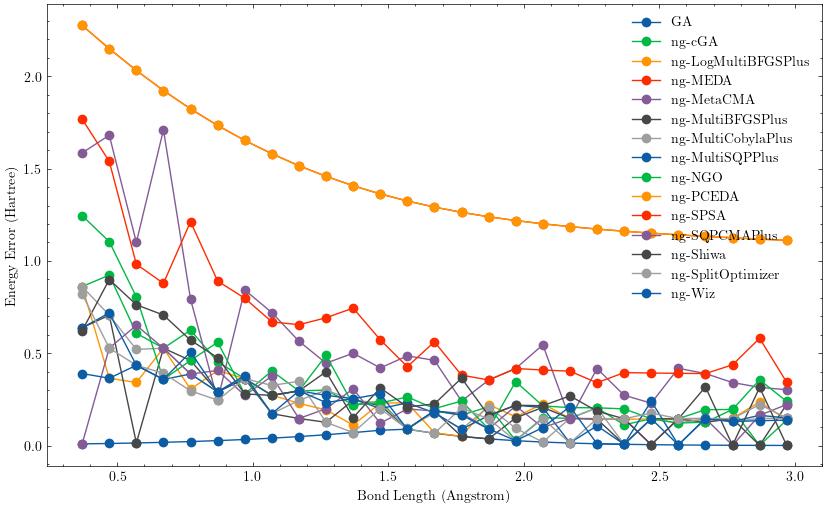

<Figure size 350x262.5 with 0 Axes>

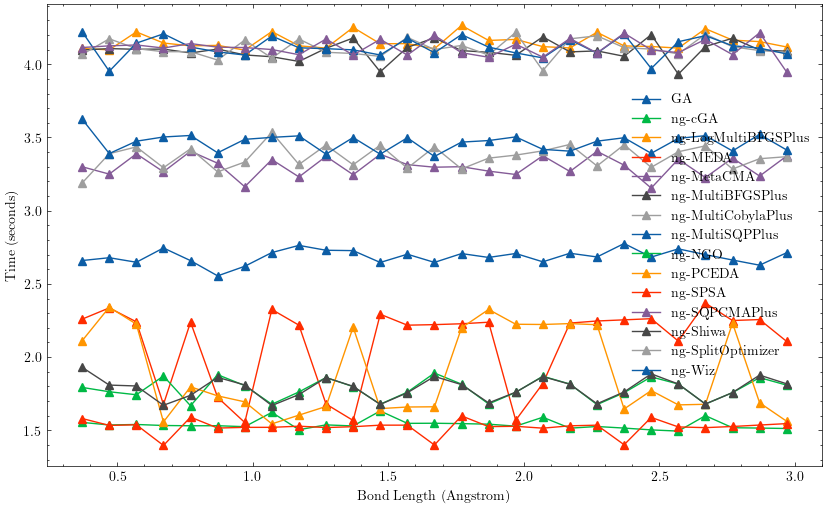

<Figure size 350x262.5 with 0 Axes>

In [26]:
plt.figure(figsize=(10, 6))
for results in results_list:
    plt.plot(results.bond_lengths, results.energy_bests, label=results.name, marker="o")
plt.xlabel("Bond Length (Angstrom)")
plt.ylabel("Energy (Hartree)")
plt.legend()
plt.show()
plt.clf()

plt.figure(figsize=(10, 6))
for results in results_list:
    if results.name == "exact":
        continue
    plt.plot(results.bond_lengths, np.array(results.energy_bests) - np.array(exact_results.energy_bests), label=results.name, marker="o")
# plt.ylim(0, 0.1)
plt.xlabel("Bond Length (Angstrom)")
plt.ylabel("Energy Error (Hartree)")
plt.legend()
plt.show()
plt.clf()

plt.figure(figsize=(10, 6))
for results in results_list:
    if results.name == "exact":
        continue
    plt.plot(results.bond_lengths, results.times, label=results.name, marker="^")
plt.xlabel("Bond Length (Angstrom)")
plt.ylabel("Time (seconds)")
plt.legend()
plt.show()
plt.clf()





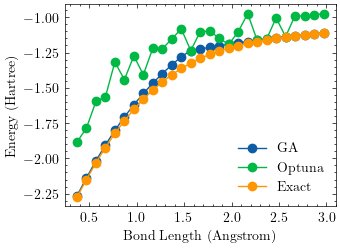

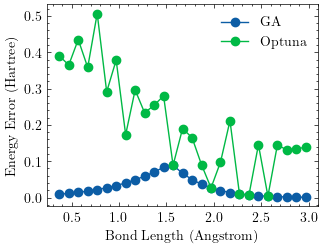

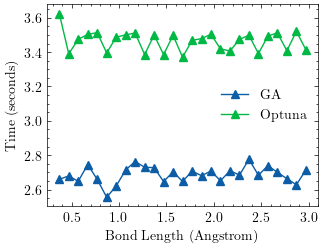

<Figure size 350x262.5 with 0 Axes>

In [27]:
plt.plot(GA_results.bond_lengths, GA_results.energy_bests, label="GA", marker="o")
plt.plot(optuna_results.bond_lengths, optuna_results.energy_bests, label="Optuna", marker="o")
plt.plot(exact_results.bond_lengths, exact_results.energy_bests, label="Exact", marker="o")
plt.xlabel("Bond Length (Angstrom)")
plt.ylabel("Energy (Hartree)")
plt.legend()
plt.show()
plt.clf()

plt.plot(GA_results.bond_lengths, np.array(GA_results.energy_bests) - np.array(exact_results.energy_bests), label="GA", marker="o")
plt.plot(optuna_results.bond_lengths, np.array(optuna_results.energy_bests) - np.array(exact_results.energy_bests), label="Optuna", marker="o")
plt.xlabel("Bond Length (Angstrom)")
plt.ylabel("Energy Error (Hartree)")
plt.legend()
plt.show()
plt.clf()


plt.plot(GA_results.bond_lengths, GA_results.times, label="GA", marker="^")
plt.plot(optuna_results.bond_lengths, optuna_results.times, label="Optuna", marker="^")
# plt.plot(exact_results.bond_lengths, exact_results.times, label="Exact", marker="^")
plt.xlabel("Bond Length (Angstrom)")
plt.ylabel("Time (seconds)")
plt.legend()
plt.show()
plt.clf()



